In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
from copy import deepcopy
from sklearn.neighbors import KernelDensity

In [4]:
# ------------ for NC and GTC related graphs w/o DOI information --------------

ltype = ['A', 'B', 'C'] # MMs
pnames = ['509', '493', '489', '487'] # patients, corresponding to 1, 2, 3, and 4 
base = 'total_data_final/'
num_models = 10 

# when R and T are marked using same MM
nc_scores_same = np.zeros((len(pnames), len(ltype))) 
nc_scores_same_am = np.zeros((len(pnames), len(ltype), num_models)) 

# when R and T are marked using distinct MMs 
nc_scores = np.zeros((len(pnames), len(ltype), len(ltype)-1)) # storing mean of models
nc_scores_am = np.zeros((len(pnames), len(ltype), len(ltype)-1, num_models)) # storing data across models


gc = np.zeros((len(pnames), 6)) # GTC scores 

for i, p in enumerate(pnames):

    gc[i] = np.load('ground_truth_global/' + p + '.npy')
    
    # gold standard MM
    for j, l in enumerate(ltype):
        
        c = 0
        
        # val predictions 
        nc_l_gold = np.load('global_nc/nc_' + p + '_' + l + '_gold.npy')
        
        for luser in ltype:
            
            # test predictions 
            nc_luser = np.load('global_nc/nc_' + p + '_' + l + '_' + luser + '.npy')
            
            if luser == l:
                nc_scores_same[i, j] = np.mean(nc_luser)/np.mean(nc_l_gold)
                nc_scores_same_am[i, j] = nc_luser/nc_l_gold
                
                
            
            else:
                nc_scores[i, j, c] = np.mean(nc_luser)/np.mean(nc_l_gold)
                nc_scores_am[i,j,c] = nc_luser/nc_l_gold
                
                c+=1
                

In [46]:
# Supplementary Figure showing variation across CNNs


#patient_avg_var = np.vstack((np.expand_dims(np.mean(np.std(nc_scores_same_am, axis=-1),axis=0),axis=-1), np.mean(np.std(nc_scores_am, axis=-1),axis=0)))

var = np.mean(np.std(nc_scores_am, axis=-1),axis=0)
var_same = np.expand_dims(np.mean(np.std(nc_scores_same_am, axis=-1),axis=0),axis=-1)

# 3 x 3 array, where each entry is the variation across N models for model 
# trained and tested on a specific MM pair 
patient_avg_var = np.hstack((var,var_same))

print(patient_avg_var)
mean = np.mean(nc_scores,axis=0)
mean_same = np.expand_dims(np.mean(nc_scores_same,axis=0),axis=-1)
# 3 x 3 array, where each entry is the variation across N models for model 
# trained and tested on a specific MM pair 
patient_avg_mean = np.hstack((mean, mean_same))
print(patient_avg_mean)



[[0.00602948 0.00675224 0.00484712]
 [0.00763658 0.00681884 0.00479889]
 [0.00357838 0.00549892 0.00555043]]
[[0.91977058 0.74934889 0.99394697]
 [0.88805013 0.82645765 0.98266321]
 [0.89907825 1.01225396 0.97402736]]


In [10]:
# ----------------- for DOI related graphs -------------------
labelspath = '/home3/ebrahim/TNEC_paper_code/experiment_data/global/'
predspath = 'unique_overlap_global/'

ltype = ['A', 'B', 'C']
pname = ['509', '493', '489', '487']

preds_arr = []
preds_arr_old = []
doi_arr = []
gc_arr = []

consis_perf = np.zeros((3, 4, 2))

num_cat = np.zeros((len(pname), 4))

thresh = .9

for j, p in enumerate(pname):
    
    for i, l in enumerate(ltype):
    
        #bins = [.01, .03, .065, .31]
            
        
        # performance on consistent HFOs 
        #consistent_HFOs = np.mean(np.load(predspath + 'model_' + l + '_global_3_' + p + '_overlap.npy'), axis=-1)
        #consis_perf[i, j] = consistent_HFOs[consistent_HFOs!=0]
        
         # load model outputs
        # unique preds are predictions for hfos that are inconsistent with the MM the model was trained on
        # overlap preds are predictions for hfos that are consistent with the MM the model was trained on
        model_preds = np.load(predspath + 'model_' + l + '_global_3_' + p + '_unique_preds.npy', allow_pickle=True)
        model_preds_consis = np.load(predspath + 'model_' + l + '_global_3_' + p + '_overlap_preds.npy', allow_pickle=True)
        
        
        c = 0
        
        for l_test in ltype:
            
             # if S2 is marked using the same methodology as S1, there are no inconsistent HFOs so continue
            if l == l_test:
                continue
                
            # load percentile scores, these are given by the M used for S1
            percentile_unq = np.load(labelspath + 'hfo_' + p + '_' + l_test + '_' + l + '_unique_percentile_labels.npy')
            percentile_overlap = np.load(labelspath + 'hfo_' + p + '_' + l_test + '_' + l + '_overlap_percentile_labels.npy')
            
            
            # compute degree of inconsistency (DOI), 0 equals no inconsistency, .9 indicates maximal inconsistency
            if l == 'A':
                doi = thresh - np.average(percentile_unq, axis=-1, weights=(1,3,1))
                gc_arr.append(np.hstack((np.average(percentile_overlap, axis=-1, weights=(1,3,1)), 
                                         np.average(percentile_unq, axis=-1, weights=(1,3,1)))))
            if l == 'B':
                doi = thresh - np.average(percentile_unq, axis=-1, weights=(3,1,1))
                gc_arr.append(np.hstack((np.average(percentile_overlap, axis=-1, weights=(3,1,1)),
                                         np.average(percentile_unq, axis=-1, weights=(3,1,1)))))
            if l == 'C':
                doi = thresh - np.average(percentile_unq, axis=-1, weights=(6,1,1))
                gc_arr.append(np.hstack((np.average(percentile_overlap, axis=-1, weights=(6,1,1)), 
                                         np.average(percentile_unq, axis=-1, weights=(6,1,1)))))
                
                
            preds = model_preds.item()[l_test]
            consis_preds = model_preds_consis.item()[l_test]
            preds_arr_old.append(np.hstack((consis_preds[:,1], 
                                        preds[:,1])))
            preds_arr.append(np.hstack((consis_preds[:,1] - consis_preds[:, 0], 
                                        preds[:,1] - preds[:, 0])))
            doi_arr.append(np.hstack((np.zeros_like(consis_preds[:,0]), doi)))
            

In [49]:
def compute_variance_consis_inconsis(doi_numpy, preds_numpy):
    
    doi_zero = np.argwhere(doi_numpy==0)
    doi_nonzero = np.argwhere(doi_numpy!=0)
    print("Standard deviation consistnet: ", np.std(preds_numpy[doi_zero]))
    print("HFO Count consistent: ", preds_numpy[doi_zero].shape)
    print("Standard deviation inconsistnet: ", np.std(preds_numpy[doi_nonzero]))
    print("HFO Count inconsistent: ", preds_numpy[doi_nonzero].shape)

In [20]:
f= [1.2, .9, .6, .3]
def make_doi_plots(doi_arr, preds_arr, gc_arr, int_mode, savefig=False):
    
    f= [1.2, .9, .6, .3] # for different colored lines for each patient
    
    fig, ax = plt.subplots(2,2,figsize=(10,8))
    c = 0
    bin_p123 = np.arange(-.01, .2, .01)
    bin_p4 = [-.04, 0, .04, .08, .12, .16, .2] # bigger bins b/c far less data for this patient 
    
    sns.set_style('white')
    
    for p in range (2):
        for p2 in range (2):
            
            if p + p2 != 2:
                bin_arr = bin_p123
                shift = .005 # for markers during plotting, shifting them so they are centered 
            else:
                bin_arr = bin_p4 
                shift = .02
                
            # select data for a single patient 
            doi_arr_patient = doi_arr[c*6:(c+1)*6]
            preds_arr_patient = preds_arr[c*6:(c+1)*6]
            gc_arr_patient = gc_arr[c*6:(c+1)*6]
            
    
            doi_numpy = np.hstack((doi_arr_patient))
            preds_numpy = np.hstack((preds_arr_patient))
            gc_numpy = np.hstack((gc_arr_patient))
            
            #compute_variance_consis_inconsis(doi_numpy, preds_numpy)
            
            print(np.min(preds_numpy))
            
            #np.savetxt('data_for_figures/figure_3_c_d_doi_patient_' + str(c+1) + '.csv', doi_numpy, delimiter=',')
            np.savetxt('data_for_figures/figure_3_c_d_preds_patient_' + str(c+1) + '.csv', preds_numpy, delimiter=',')
            #np.savetxt('data_for_figures/figure_3_c_d_gc_patient_' + str(c+1) + '.csv', gc_numpy, delimiter=',')
            

            # integer mode, predictions are converted into a binary array 
            # for making DOI graphs w/o sigmoid score output
            if int_mode:
                preds_numpy[preds_numpy>0]=1
                preds_numpy[preds_numpy!=1]=0 

                consis_preds = np.argwhere(preds_numpy==1)
                inconsis_preds = np.argwhere(preds_numpy==0)

                doi_numpy_graphical = deepcopy(doi_numpy)
                doi_numpy_graphical[doi_numpy_graphical==0] = -.01

                # compute fraction of inconsistent class predictions (by network) for each DOI bin
                consis_pred_dois = doi_numpy_graphical[consis_preds]
                inconsis_pred_dois = doi_numpy_graphical[inconsis_preds]

                hist_consis, bins_consis = np.histogram(consis_pred_dois, bins=bin_arr)
                hist_inconsis, bins_inconsis = np.histogram(inconsis_pred_dois, bins=bin_arr)
                frac_inconsis = hist_inconsis / (hist_inconsis+hist_consis)
                hist_consis, bins_consis = np.histogram(consis_pred_dois, bins=bin_arr)
                hist_inconsis, bins_inconsis = np.histogram(inconsis_pred_dois, bins=bin_arr)
                frac_inconsis = hist_inconsis / (hist_inconsis+hist_consis)
                print("PARTICIPANT NUMBER: ", c+1)
                print("Fraction inconsistent: ", frac_inconsis[1])
                print("DOI BINS: ", bins_inconsis[1:3])
                print("N : ", hist_inconsis[1])
                

                n, bins, patches = ax[p, p2].hist(doi_numpy_graphical, color=(.4, .8, .7), log=True, bins=bin_arr, 
                                  edgecolor='white', alpha=.6)

                patches[0].set_facecolor(color=(.3, .3, .3))
                for j in range(1,len(bins)-1,1):
                    patches[j].set_facecolor(color=(.6, .6, .6))

                ax[p, p2].set_xlim(bin_arr[0]-.01, .2)
                ax[p, p2].set_xticks([0, .1])

                if p == 1:
                    ax[p, p2].set_xlabel("DOI", fontsize=16)

                if p2 == 0:
                    ax[p, p2].set_ylabel("HFO Count", fontsize=16)

                ax2 = ax[p, p2].twinx() 
                ax2.plot(bins_inconsis[:-1]+shift, frac_inconsis, marker='o', markersize=6, color=(.4*f[c], .8*f[c], .7*f[c]), linewidth=3)
                ax2.set_ylim(0,1.05)
                ax2.set_yticks([0, 1])
                ax2.plot()
                
            else:
                sns.despine()
                ax[p, p2].set_ylim(-.05,1.05)
                ax[p, p2].set_xlim(-1e-2, .35)
                
                pear, pval = pearsonr(doi_numpy, preds_numpy)
                
                sns.regplot(x=doi_numpy, y=preds_numpy, truncate=True, 
                            scatter_kws={'color':(.4*f[c], .8*f[c], .7*f[c]), 'edgecolor':'white', 'alpha':.8},
                            line_kws = {'color':(0,0,0)}, ci=None, order=1,
                                ax=ax[p, p2])
                
                ax[p, p2].text(.24, .8, 'r = ' + str(pear)[0:5], fontsize=12)
                ax[p, p2].text(.24, .7, 'p <. 001')
                
                
                if p2==0:
                    ax[p,p2].set_yticks([-1, 1])
                    ax[p,p2].set_ylabel("Network output", fontsize=16)
                else:
                    ax[p,p2].set_yticks([])
                if p==1:
                    ax[p,p2].set_xticks([0, .1, .2, .3])
                    ax[p,p2].set_xlabel("DOI", fontsize=16)
                else:
                    ax[p,p2].set_xticks([])
                
            c+=1
    if savefig: 
        if int_mode:
            plt.savefig('Consistency_Figures_pdf/doi_global.pdf', dpi=400, bbox_inches='tight', format='pdf')
            plt.savefig('Consistency_Figures_png/doi_global', dpi=400, bbox_inches='tight')
        else:
            pass
            plt.savefig('Consistency_Figures_pdf/sigmoid_global.pdf', dpi=400, bbox_inches='tight', format='pdf')
            plt.savefig('Consistency_Figures_png/sigmoid_global', dpi=400, bbox_inches='tight')
        plt.show()

In [68]:
nc_scores = np.squeeze(nc_scores)
nc_scores_format = np.zeros((len(pnames),6))
for i in range(4): 
    nc_scores_format[i] = [nc_scores[i,1,0], nc_scores[i,0,0], nc_scores[i,2,0], nc_scores[i,0,1], nc_scores[i,2,1], nc_scores[i,1,1]]

0.9974832779938356 9.492864164726714e-06
0.9853767754402709 0.0003191945391469788
0.9836957918073296 0.00039657375613982653
0.9653751750590028 0.001777562274160041


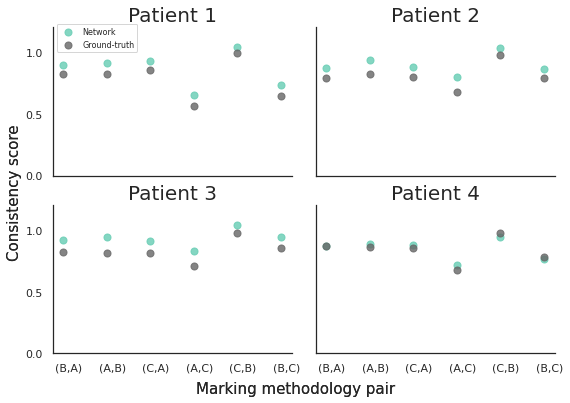

In [69]:
indices = ['(B,A)', '(A,B)', '(C,A)', '(A,C)', '(C,B)', '(B,C)']
fig, ax = plt.subplots(2,2,figsize=(9,6))
z=0
y_ind = np.arange(.2, 1.19, .2)

plt.subplots_adjust(wspace=.1)

sns.set_theme()
sns.set_style('white')
sns.despine()

c=1
for i in range(2):
    for j in range(2):
        
        p, pval = pearsonr(gc[z], nc_scores_format[z])
        print(p, pval)
        
        ax[i,j].set_ylim(0,1.2)
        
        if i == 1:
            ax[i,j].set_xticks(np.arange(0,6,1)+.125)
            #ax[i,j].set_xlabel("Marking methodology pair", fontsize=16)
            ax[i,j].set_xticklabels(indices)
        else:
            ax[i,j].set_xticks([])
            
        if j==0:
            ax[i,j].set_yticks([0, .5, 1.0])
            #ax[i,j].set_ylabel("Consistency score", fontsize=16)
        else:
            ax[i,j].set_yticks([])
            
        for p in y_ind:
            ax[i,j].axhline(p, color=(1,1,1), zorder=0)
        
        ax[i,j].scatter(np.arange(0,6,1), np.squeeze(nc_scores_format[z]), color=(.4, .8, .7), s=50, label='Network', alpha=.8)
        ax[i,j].scatter(np.arange(0,6,1), gc[z], color=(.4,.4,.4), s=50, label='Ground-truth', alpha=.8)
        ax[i,j].set_title("Patient " + str(c), fontsize=20)
        
        if i == 0 and j == 0:
            handles, labels = ax[i,j].get_legend_handles_labels()
            ax[i,j].legend(handles, labels, bbox_to_anchor=(0., .95, 1., .102), loc='upper left', prop={'size':8})
        
      
        z+=1
        c+=1
        
    fig.text(0.055, 0.5, 'Consistency score', va='center', rotation='vertical', fontsize=15)
    fig.text(0.5, 0.034, 'Marking methodology pair', ha='center', fontsize=15)
        
#plt.savefig('Consistency_Figures_png/patient_global', dpi=400, bbox_inches='tight')
#plt.savefig('Consistency_Figures_pdf/patient_global.pdf', dpi=400, bbox_inches='tight', format='pdf')

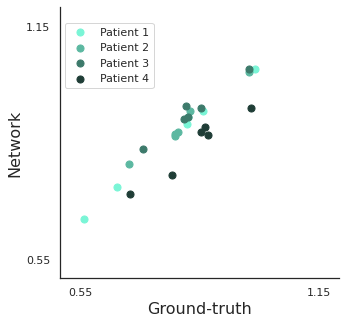

In [19]:
f= [1.2, .9, .6, .3]
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.set_theme()
sns.set_style('white')
sns.despine()
for i, (n,g) in enumerate(zip(nc_scores_format, gc)):
    ax.set_xlabel("Ground-truth", fontsize=16)
    ax.set_ylabel("Network", fontsize=16)
    ax.set_xticks([.55, 1.15])
    ax.set_yticks([.55, 1.15])
    ax.set_ylim(.5, 1.2)
    ax.set_xlim(.5, 1.2)
    ax.scatter(g, n, color=(.4*f[i],.8*f[i],.7*f[i]), label='Patient ' + str(i+1), s=50)
fig.legend(bbox_to_anchor=(-.6, -.15,1,1))
plt.savefig('Consistency_Figures_png/global_corr', dpi=400, bbox_inches='tight')
plt.savefig('Consistency_Figures_pdf/global_corr.pdf', dpi=400, bbox_inches='tight', format='pdf')

-0.9998228
PARTICIPANT NUMBER:  1
Fraction inconsistent:  0.41354166666666664
DOI BINS:  [0.   0.01]
N :  794
-0.99943614
PARTICIPANT NUMBER:  2
Fraction inconsistent:  0.36208688422365415
DOI BINS:  [0.   0.01]
N :  1742
-0.99997663
PARTICIPANT NUMBER:  3
Fraction inconsistent:  0.3568260226712666
DOI BINS:  [0.   0.01]
N :  1448
-0.9998414
PARTICIPANT NUMBER:  4
Fraction inconsistent:  0.6777777777777778
DOI BINS:  [0.   0.04]
N :  183


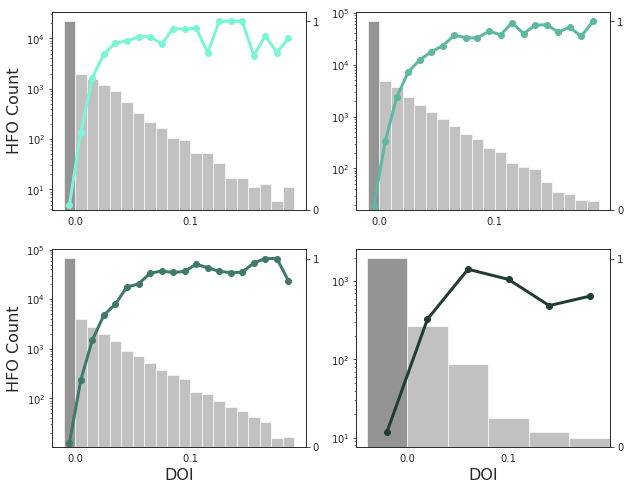

In [21]:
make_doi_plots(doi_arr, preds_arr, gc_arr, int_mode=True)

In [27]:
np.savetxt("data_for_figures/figure_3_a_b_nc_scores.csv", nc_scores_format, delimiter=",")
np.savetxt("data_for_figures/figure_3_a_b_gtc_scores.csv", gc, delimiter=",")

In [ ]:
# ---------------------- OLD CODE ---------------------------------------


In [4]:
def organize_doi(setting, doi, c, i, j, cat1_perf, cat2_perf, cat3_perf, cat4_perf, num_cat, bins, preds):
    
    # if category is true, give % of consistent predictions by doi category
    # if false, returns average model pred before conversion to integer for each doi category
    
     # find indices corresponding to categories for each HFO in S2 
    cat1 = np.argwhere(doi < bins[0])
    cat2 = np.intersect1d(np.argwhere(doi > bins[0]), np.argwhere(doi < bins[1]))
    cat3 = np.intersect1d(np.argwhere(doi > bins[1]), np.argwhere(doi < bins[2]))
    cat4 = np.intersect1d(np.argwhere(doi > bins[2]), np.argwhere(doi < bins[3]))
    
    num_cat[j, 0] += cat1.shape[0]
    num_cat[j, 1] += cat2.shape[0]
    num_cat[j, 2] += cat3.shape[0]
    num_cat[j, 3] += cat4.shape[0]

    preds_int = np.argmax(preds, axis=-1)
    preds = preds[:,1] # consistent class preds
    
    if setting == 0 or setting == 1:
        
        # store model performance for each category 
        try:
            cat1_perf[i, j, c] = transformation(setting, preds_int, preds, cat1)
        except:
            cat1_perf[i,j,c] = np.nan
        try:
            cat2_perf[i, j, c] = transformation(setting, preds_int, preds, cat2)
        except:
            cat2_perf[i,j,c] = np.nan

        try:
            cat3_perf[i, j, c] = transformation(setting, preds_int, preds, cat3)
        except:
            cat3_perf[i,j,c] = np.nan

        try:
            cat4_perf[i, j, c] = transformation(setting, preds_int, preds, cat4)
        except:
            cat4_perf[i,j,c] = np.nan
                
    else:
        
        cat1_perf.append(transformation(setting, preds_int, preds, cat1))
        cat2_perf.append(transformation(setting, preds_int, preds, cat2))
        cat3_perf.append(transformation(setting, preds_int, preds, cat3))
        cat4_perf.append(transformation(setting, preds_int, preds, cat4))
                
        
        
    c += 1
    return c, cat1_perf, cat2_perf, cat3_perf, cat4_perf, num_cat

In [71]:
def plot_inconsistent_HFO_perf(consis_perf, cat1, cat2, cat3, cat4, setting):
    
    if setting==0:
        #title = "Global consistency predictions modulated by DOI"
        title=''
        ylabel = '% consistent predictions '
        start=0
        save_name = 'inconsistent_HFOs_global'
        f=100
    else:
        #title = "Global patient network"
        ylabel = 'Mean sigmoid score '
        start=1
        save_name = 'sigmoid_inconsistent_HFOs_global'
        f=1
        
    
    x = np.asarray([0, .0075, .03, .0675, .2])
    x_487 = [0, .0075, .03, .135]
    
    mean_cat1 = np.nanmean(cat1,axis=(0,2))*f
    mean_cat2 = np.nanmean(cat2,axis=(0,2))*f
    mean_cat3 = np.nanmean(cat3,axis=(0,2))*f
    mean_cat4 = np.nanmean(cat4,axis=(0,2))*f
    mean_consis = np.nanmean(consis_perf, axis=(0,2))*f
    
    std_cat1 = np.nanstd(cat1,axis=(0,2))
    std_cat2 = np.nanstd(cat2,axis=(0,2))
    std_cat3 = np.nanstd(cat3,axis=(0,2))
    std_cat4 = np.nanstd(cat4,axis=(0,2))
    std_consis = np.nanstd(consis_perf, axis=(0,2))
    
    jitter = 2e-2
    
    cat_509_mean = [mean_consis[0] - jitter, mean_cat1[0], mean_cat2[0], mean_cat3[0], mean_cat4[0]]
    cat_509_std = [std_consis[0], std_cat1[0], std_cat2[0], std_cat3[0], std_cat4[0]]
    
    cat_493_mean = [mean_consis[1] + jitter, mean_cat1[1], mean_cat2[1], mean_cat3[1], mean_cat4[1]]
    cat_493_std = [std_consis[1], std_cat1[1], std_cat2[1], std_cat3[1], std_cat4[1]]
    
    cat_489_mean = [mean_consis[2], mean_cat1[2], mean_cat2[2], mean_cat3[2], mean_cat4[2]]
    cat_487_mean = [mean_consis[3], mean_cat1[3], mean_cat2[3], (mean_cat3[3] + mean_cat4[3])/2]
    
    
    fig, ax = plt.subplots(1,1, figsize=(8.5,3.5))
    
    sns.set_theme()
    sns.set_style('white')
    sns.despine()
    
    ax.plot(x[start:], cat_509_mean[start:], '-', marker='o', label='Patient 1', linewidth=3, markersize=10, color=(.4*1.2,.8*1.2,.7*1.2))    
    ax.plot(x[start:], cat_493_mean[start:], '-', marker='o',  label='Patient 2', linewidth=3, markersize=10, color=(.4*.9,.8*.9,.7*.9))    
    ax.plot(x[start:], cat_489_mean[start:], 'o-', label='Patient 3', linewidth=3, markersize=10, color=(.4*.6,.8*.6,.7*.6))
    ax.plot(x_487[start:], cat_487_mean[start:], '-', marker='o', label='Patient 4', linewidth=3, markersize=10, color=(.4*.3,.8*.3,.7*.3))
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xlabel('Degree of inconsistency (DOI)', fontsize=15)
    plt.legend()
    if setting==1:
        ax.axhline(.5, linestyle='--')
    ax.set_title(title, fontsize=17)
    ax.set_xticks([.2, .1, 0])
    ax.set_yticks([0, .5*f, 1.0*f])
    ax.set_ylim(0,f*1.05)
    
    plt.savefig('Consistency_Figures/' + save_name, dpi=400, bbox_inches='tight')
    plt.savefig('Consistency_Figures_pdf/' + save_name + '.pdf', dpi=400, bbox_inches='tight', format='pdf')